# Santa Barbara County Vineyards Analysis 2023

**Authors:** 
Gregory Halverson
Claire Villanueva-Weeks
Jet Propulsion Laboratory, California Institute of Technology

This research was carried out at the Jet Propulsion Laboratory, California Institute of Technology, and was sponsored by ECOSTRESS and the National Aeronautics and Space Administration (80NM0018D0004). 

© 2023. All rights reserved.
 ___
### Summary and Background
 Santa Barbara County is a well known for its viticulture. Positioned near the ocean, the unique topography of Santa Barbara allows for unique microclimates that yield diverse crops and wines. In this notebook, we aim to visualize and analyze Vineyard health using Earth observation data from two different satellite products: the EMIT L2A Reflectance product stored in NETCDF4 format and an ECOSTRESS L2 Land Surface Temperature product stored in GEOTIFF format. Our goal is to visualize Normalized Difference Vegetation Index (NDVI), Estimated Water Thickness (EWT), Evapotranspiration (ET), and Surface Temperature (ST) interactively in `holoviews` maps and generate linear regression plots of point source data.

<figure align="center">
  <img src="../img/vineyard_stock_image.jpg" width="200" height="200"/>
    <figcaption>Figure 1. Vineyard.</figcaption> 
</figure>

### Tutorial references
01_Finding_Concurrent_Data.ipynb 
- Finding and downloading concurrent EMIT and ECOSTRESS data with earthaccess

03_EMIT_CWC_from_Reflectance.ipynb
- Calculating EWT of ROI

03_EMIT_Inreractive_Points.ipynb
- Generating a map with clickable points

### Required datasets  
- EMIT Reflectance
    - EMIT_L2A_RFL_001_20230401T203803_2309114_003.nc

- EMIT Canopy Water Content
    - EMIT_L2A_RFL_001_20230401T203751_2309114_002_roi_bbox_cwc_merged.tif

- ECOSTRESS Land Surface Temperature
    - ECOv002_L2T_LSTE_26860_001_10SGD_20230401T203733_0710_01_LST.tif

- ECOSTRESS Evapotranspiration
    - ECOv002_L3T_JET_26860_001_10SGD_20230401T203732_0700_01_ETdaily.tif
    
- SB_ROI_ag.geojson: This file includes polygons of delinated agricultural field boundaries. It has been clipped to our ROI and fields were edited for ease of usability. 

#### Tutorial Outline  
5.1 Set up
5.2 Locating Data Sources and Loading Data
5.3 Color Hex-Codes for Raster Plots
5.4 Subseting the data over our ROI
5.5 Interactive Maps
5.6 Scatter Plots

---
#### References
1. Jackson, M. (2018). Santa Barbara County (Images of America). Arcadia Publishing.
2. [CalAgData](https://cosantabarbara.app.box.com/s/jdt95fy7gst3g8649l9t3ukrorr5xeh9)

---
## 5.1 Set up 

These are some built-in Python functions we need for this notebook, including functions for handling filenames and dates.

We're using the `rioxarray` package for loading raster data from a GeoTIFF file, and we're importing it as `rxr`. We're using the `numpy` library to handle arrays, and we're importing it as `np`. We're using the `rasterio` package to subset the data.

We're using the `geopandas` library to load vector data from GeoJSON files, and we're importing it as `gpd`. We're using the `shapely` library to handle vector data and the `pyproj` library to handle projections.

Import the `emit_tools` module and call use from emit_tools import emit_xarray
help(emit_xarray) the help function to see how it can be used.

> Note: This function currently works with L1B Radiance and L2A Reflectance Data.

In [1]:
# mamba install -c pyviz hvplot holoviews geoviews cartopy

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
from os.path import join, expanduser, splitext, basename
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import holoviews as hv
import hvplot.xarray
import hvplot.pandas
import geoviews as gv
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import rasterio as rio
from holoviews.streams import SingleTap
from scipy.stats import linregress

Importing Custom EMIT Tools to handle the EMIT reflectance data

In [2]:
# sys.path,append thing might work in 2i2c instead
from modules.emit_tools import emit_xarray, ortho_xr

We can define these constants to prescribe the dimensions of our figures. Feel free to adjust these to fit your display. We're setting the alpha to make the raster semi-transparent on top of the basemap.

In [3]:
FIG_WIDTH_PX = 1080
FIG_HEIGHT_PX = 720
FIG_WIDTH_IN = 16
FIG_HEIGHT_IN = 9
FIG_ALPHA = 0.7
BASEMAP = "EsriImagery"
SEABORN_STYLE = "whitegrid"
FILL_COLOR = "none"
LINE_COLOR = "red"
LINE_WIDTH = 3
WEBMAP_PROJECTION = "EPSG:3857"
sns.set_style(SEABORN_STYLE)

## 5.2 Locating Data Sources and Loading Data

Here we are defining location of EMIT and ECOSTRESS raster files.

In [4]:
# data_dir = join(expanduser("~"), "Desktop/workshopdata")
data_dir = "/home/jovyan/shared/2023-VITALS-Workshop-AGU/data/" 
# data_dir = '/home/jovyan/VITALS.git/data/'
# data_dir = "../../shared/2023-VITALS-Workshop-AGU/data/cropped/dangermond"
data_dir

'/home/jovyan/shared/2023-VITALS-Workshop-AGU/data/'

Here we are loading in our vector data source. We can image the delineated agricultural field boundaries and take a look at the fields.

In [5]:
ag_file = join(data_dir,"SB_ROI_ag.geojson")
# ag_file = '/../../2023-VITALS-Workshop-AGU/data/SB_ROI_ag.geojson'
# cut out the agroi section 
ag_latlon = gpd.read_file(ag_file)

ag_fig = ag_latlon.to_crs(WEBMAP_PROJECTION).hvplot.polygons(
    tiles=BASEMAP,
    line_color = LINE_COLOR,
    line_width = LINE_WIDTH,
    fill_color = FILL_COLOR
) 

ag_fig

:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Polygons.I :Polygons   [x,y]

In [7]:
ag_latlon

,OBJECTID,permittee,site_name,size,size_units,crop_list,calc_acres,mtrs,geometry
0,3654110,CENT ANNI-COASTAL VINEYARD CARE,CENT ANNI,8.0,ACRES,"VERTEBRATE CTRL, GRAPE, WINE, UNCULTIVATED AG",1.463097,S07N34W11,"MULTIPOLYGON (((-8064.151 -373076.101, -8058.8..."
1,3671186,CENT ANNI-COASTAL VINEYARD CARE,CENT ANNI,8.0,ACRES,"VERTEBRATE CTRL, GRAPE, WINE, UNCULTIVATED AG",1.232124,S07N34W11,"MULTIPOLYGON (((-8220.677 -373296.021, -8205.1..."
2,3671187,CENT ANNI-COASTAL VINEYARD CARE,CENT ANNI,8.0,ACRES,"VERTEBRATE CTRL, GRAPE, WINE, UNCULTIVATED AG",2.782784,S07N34W11,"MULTIPOLYGON (((-8185.460 -372957.510, -8146.0..."
3,4829810,CHUMASH VINEYARDS LLC- COASTAL VINEYARD,CAMP 4 -,280.0,ACRES,"VERTEBRATE CTRL, GRAPE, WINE, UNCULTIVATED AG",277.792034,S06N30W05,"MULTIPOLYGON (((-5734.564 -375663.536, -5340.6..."
4,3681606,GREAT OAKS RANCH-FINKLE,GREAT OAKS RANCH VINEYARD - ALL PLOTS,20.0,ACRES,"VERTEBRATE CTRL, GRAPE, WINE, UNCULTIVATED AG",15.713672,S07N30W30,"MULTIPOLYGON (((-8104.976 -374002.479, -8098.9..."
...,...,...,...,...,...,...,...,...,...
463,8928511,BROTHERS BEST PRODUCE,ARBELAITZ RANCH,12.0,ACRES,"OAT, Rotational Crops",11.131229,S07N31W36,"MULTIPOLYGON (((-8961.836 -375463.076, -8960.0..."
464,8928512,BROTHERS BEST PRODUCE,SITE 06: MORO RANCH TRI-CLOR EC,15.0,ACRES,SQUASH,14.690810,S07N30W32,"MULTIPOLYGON (((-4728.422 -374455.107, -4732.8..."
465,8928514,BROTHERS BEST PRODUCE,SHEPPARD RANCH,108.0,ACRES,"OAT, Rotational Crops",110.279936,S06N30W05,"MULTIPOLYGON (((-6938.727 -376457.113, -5628.6..."
466,8945655,CAMARILLO FARMING,SITE 01 BASELINE AVE RANCH,8.0,ACRES,"PEPPER FRUITNG, TOMATILLO, CABBAGE",7.910668,S07N31W36,"MULTIPOLYGON (((-8567.652 -375377.567, -8567.0..."


### Loading in EMIT reflectance data
To open up the EMIT `.nc` file we will use the `netCDF4`, `xarray` and `emit_tools` libraries. 

In [8]:
EMIT_fp = join(data_dir, "EMIT_L2A_RFL_001_20230401T203803_2309114_003.nc") 
EMIT_fp

'/home/jovyan/shared/2023-VITALS-Workshop-AGU/data/EMIT_L2A_RFL_001_20230401T203803_2309114_003.nc'

In [9]:
refl_ds = emit_xarray(EMIT_fp, ortho=True)
refl_ds

<xarray.Dataset>
Dimensions:           (latitude: 1895, longitude: 2368, wavelengths: 285)
Coordinates:
  * wavelengths       (wavelengths) float32 381.0 388.4 ... 2.486e+03 2.493e+03
    fwhm              (wavelengths) float32 ...
    good_wavelengths  (wavelengths) float32 ...
  * latitude          (latitude) float64 35.31 35.3 35.3 ... 34.28 34.28 34.28
  * longitude         (longitude) float64 -120.3 -120.3 -120.3 ... -119.1 -119.1
    elev              (latitude, longitude) float32 nan nan nan ... nan nan nan
    spatial_ref       int64 0
Data variables:
    reflectance       (latitude, longitude, wavelengths) float32 nan nan ... nan
Attributes: (12/40)
    ncei_template_version:             NCEI_NetCDF_Swath_Template_v2.0
    summary:                           The Earth Surface Mineral Dust Source ...
    keywords:                          Imaging Spectroscopy, minerals, EMIT, ...
    Conventions:                       CF-1.63
    sensor:                            EMIT (Earth Surface Mineral Dust Sourc...
    instrument:                        EMIT
    ...                                ...
    spatial_ref:                       GEOGCS["WGS 84",DATUM["WGS_1984",SPHER...
    geotransform:                      [-1.20348784e+02  5.42232520e-04 -0.00...
    day_night_flag:                    Day
    title:                             EMIT L2A Estimated Surface Reflectance...
    granule_id:                        EMIT_L2A_RFL_001_20230401T203803_23091...
    Orthorectified:                    True

Here some functions are set up to 

## 5.3 Color Hex-Codes for Raster Plots
Here we have set up convenience functions for interpolating Color Hex-Codes for Raster Plots

In [10]:
def interpolate_hex(hex1, hex2, ratio):
    rgb1 = [int(hex1[i:i+2], 16) for i in (1, 3, 5)]
    rgb2 = [int(hex2[i:i+2], 16) for i in (1, 3, 5)]
    rgb = [int(rgb1[i] + (rgb2[i] - rgb1[i]) * ratio) for i in range(3)]
    
    return '#{:02x}{:02x}{:02x}'.format(*rgb)

def create_gradient(colors, steps):
    gradient = []
    
    for i in range(len(colors) - 1):
        for j in range(steps):
            ratio = j / float(steps)
            gradient.append(interpolate_hex(colors[i], colors[i+1], ratio))
    
    gradient.append(colors[-1])
    
    return gradient

def plot_cmap(cmap):
    gradient = np.linspace(0, 1, 256)  # Gradient from 0 to 1
    gradient = np.vstack((gradient, gradient))  # Make 2D image

    # Display the colormap
    plt.figure(figsize=(6, 2))
    plt.imshow(gradient, aspect='auto', cmap=cmap)
    plt.axis('off')
    plt.show()

### Near-Infrared and Red Bands in EMIT Hyperspectral Cube

These are the `nearest` to 800 nm and 675 nm wavelengths, they can be used to calculate the NDVI using a ratio of the difference between between the wavelengths to the sum of the wavelengths. NDVI is a metric by which we can estimate vegetation greenness.

The `hvplot` package extends `xarray` to allow us to plot maps. We're reprojecting the raster geographic projection **EPSG 4326** to overlay on the basemap with a latitude and longitude graticule. We will be using hvplot a few more times to look at the data we are using.

#### Defining Color-Map for Near Infrared

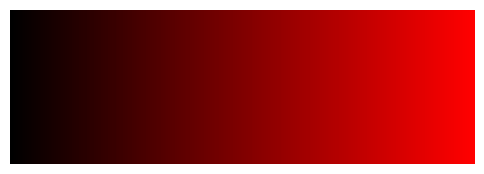

In [11]:
NIR_colors = ["#000000", "#FF0000"]
NIR_gradient = create_gradient(NIR_colors, 100)
NIR_cmap = LinearSegmentedColormap.from_list(name="NIR", colors=NIR_colors)
plot_cmap(NIR_cmap)

#### Extracting 800 nm Near Infrared from EMIT

In [12]:
NIR = refl_ds.sel(wavelengths=800, method="nearest")
NIR.rio.to_raster("NIR_800.tif")
NIR = rxr.open_rasterio('NIR_800.tif').squeeze("band", drop=True)
NIR_vmin, NIR_vmax = np.nanquantile(np.array(NIR), [0.02, 0.98])
NIR_title = f"{splitext(basename(EMIT_fp))[0]} ~800 nm"

NIR.rio.reproject("EPSG:3857").hvplot.image(
    geo=True,
    rasterize=True, 
    cmap=NIR_gradient, 
    alpha=FIG_ALPHA, 
    tiles=BASEMAP,
    clim=(NIR_vmin, NIR_vmax),
    title=NIR_title
)

/srv/conda/envs/notebook/lib/python3.10/site-packages/osgeo/osr.py:385: FutureWarning: Neither osr.UseExceptions() nor osr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'y_limits'

### Defining Color-Map for Red

In [ ]:
red_colors = ["#000000", "#FF0000"]
red_gradient = create_gradient(red_colors, 100)
red_cmap = LinearSegmentedColormap.from_list(name="red", colors=red_colors)
plot_cmap(red_cmap)

#### Extracting 675 nm Red from EMIT

In [ ]:
red = refl_ds.sel(wavelengths=675, method="nearest")
red.rio.to_raster("red_675.tif")
red = rxr.open_rasterio('red_675.tif').squeeze("band", drop=True)
red_vmin, red_vmax = np.nanquantile(np.array(red), [0.02, 0.98])
red_title = f"{splitext(basename(EMIT_fp))[0]} ~675 nm"

red.rio.reproject("EPSG:3857").hvplot.image(
    geo=True,
    rasterize=True, 
    cmap=red_gradient, 
    alpha=FIG_ALPHA, 
    tiles=BASEMAP,
    clim=(red_vmin, red_vmax),
    title=red_title
)

### Defining Color-Map for Vegetation Index

In [ ]:
NDVI_colors=[
    "#0000ff",
    "#000000",
    "#745d1a",
    "#e1dea2",
    "#45ff01",
    "#325e32"
]

NDVI_gradient = create_gradient(NDVI_colors, 100)
NDVI_cmap = LinearSegmentedColormap.from_list(name="NDVI", colors=NDVI_colors)
plot_cmap(NDVI_cmap)

#### Calculating Vegetation Index

In [ ]:
NDVI = (NIR - red)/(NIR + red)
NDVI.rio.to_raster("NDVI.tif")
NDVI = rxr.open_rasterio("NDVI.tif").squeeze("band", drop=True)
NDVI_vmin, NDVI_vmax = np.nanquantile(np.array(NDVI), [0.02, 0.98])
NDVI_title = "Normalized Difference Vegetation Index"

NDVI_scene_map = NDVI.rio.reproject("EPSG:3857").hvplot.image(
    geo=True,
    rasterize=True, 
    cmap=NDVI_gradient, 
    alpha=FIG_ALPHA, 
    tiles=BASEMAP,
    clim=(NDVI_vmin, NDVI_vmax),
    title=NDVI_title
)

NDVI_scene_map

### Loading in and visualizing our EWT data 

We can now open up the EWT data that you calculated earlier with the LP DAAC EWT !TODO. The dataset is now in .tif format which means we can just open this one up

In [ ]:
EWT_filename = join(data_dir,'EMIT_L2A_RFL_001_20230401T203751_2309114_002_roi_bbox_cwc_merged.tif') #!TODO change to 2i2c path later
EWT_filename

#### Defining Color-Map for EWT

In [ ]:
EWT_colors = ["#FFFFFF", "#0000FF"]
EWT_gradient = create_gradient(EWT_colors, 100)
EWT_cmap = LinearSegmentedColormap.from_list(name="EWT", colors=EWT_colors)
plot_cmap(EWT_cmap)

#### Mapping EWT with color ramp

In [ ]:
EWT = rxr.open_rasterio(EWT_filename).squeeze("band", drop=True)
EWT_vmin, EWT_vmax = np.nanquantile(np.array(EWT), [0.02, 0.98])
EWT_title = "Estimated Water Thickness "

EWT.rio.reproject("EPSG:3857",nodata=np.nan).hvplot.image(
    geo=True,
    rasterize=True, 
    cmap=EWT_gradient, 
    alpha=FIG_ALPHA, 
    tiles=BASEMAP,
    clim=(EWT_vmin, EWT_vmax),
    title=EWT_title
)

### Loading an ECOSTRESS LST granule

In [ ]:
ST_filename = join(data_dir, "ECOv002_L2T_LSTE_26860_001_10SGD_20230401T203733_0710_01_LST.tif") #!TODO change to 2i2c path later
ST_filename

The temperatures in the `L2T_LSTE` product are given in Kelvin. To convert them to Celsius, we subtract 273.15.

In [ ]:
ST_K = rxr.open_rasterio(ST_filename).squeeze('band', drop=True)
ST_C = ST_K - 273.15

ST_C.rio.to_raster("ST.tif")

ST_vmin, ST_vmax = np.nanquantile(np.array(ST_C), [0.02, 0.98])
ST_title = "ECOSTRESS Surface Temperature (Celsius)"

ST_C.rio.reproject("EPSG:3857",nodata=np.nan).hvplot.image(
    # geo=True,
    rasterize=True, 
    cmap="jet", 
    alpha=FIG_ALPHA, 
    # tiles=BASEMAP,
    clim=(ST_vmin, ST_vmax),
    title=ST_title
)


### Defining Color Ramps 

Color ramps, are used to map valued over a range of colors based on the data and goals of visualization. We've traditionally used the "jet" rainbow color-scheme to represent temperature, but this color-scheme is not accessible for all vision types.

Red-green colorblindness or Deuteranomoly affects approxiately 10% of people, so we are working on making a color ramp with that in mind. You can use hex codes to program in your own colors!

In [ ]:
ST_colors = [
    "#054fb9",
    "#0073e6",
    "#8babf1",
    "#cccccc",
    "#e1ad01",
    "#f57600",
    "#c44601"
]

ST_gradient = create_gradient(ST_colors, 100)
ST_cmap = LinearSegmentedColormap.from_list(name="ST", colors=ST_colors)
plot_cmap(ST_cmap)

In [ ]:
ST_vmin, ST_vmax = np.nanquantile(np.array(ST_C), [0.02, 0.98])
ST_title = "ECOSTRESS Surface Temperature (Celsius)"

ST_C.rio.reproject("EPSG:3857").hvplot.image(
    # geo=True,
    rasterize=True, 
    cmap=ST_gradient, 
    alpha=FIG_ALPHA, 
    # tiles=BASEMAP,
    clim=(ST_vmin, ST_vmax),
    title=ST_title
)

### Loading ECOSTRESS Evapotranspiration granule

In [ ]:
ET_filename = join(data_dir, "ECOv002_L3T_JET_26860_001_10SGD_20230401T203732_0700_01_ETdaily.tif")
ET_filename

We have an established color-map for representing ECOSTRESS evapotranspiration that we believe to be inclusive.

In [ ]:
ET_colors = [
    "#f6e8c3",
    "#d8b365",
    "#99974a",
    "#53792d",
    "#6bdfd2",
    "#1839c5"
]

ET_gradient = create_gradient(ET_colors, 100)
ET_cmap = LinearSegmentedColormap.from_list(name="ET", colors=ET_colors)
plot_cmap(ET_cmap)

The daily evapotranspiration product from ECOSTRESS is given in millimeters per day.

In [ ]:
ET = rxr.open_rasterio(ET_filename).squeeze('band', drop=True)
ET_vmin, ET_vmax = np.nanquantile(np.array(ET), [0.02, 0.98])
ET_title = "ECOSTRESS Evapotranspiration (mm / day)"

ET.rio.reproject("EPSG:3857").hvplot.image(
    # geo=True,
    rasterize=True, 
    cmap=ET_gradient, 
    alpha=FIG_ALPHA, 
    # tiles=BASEMAP,
    clim=(ET_vmin, ET_vmax),
    title=ET_title
)

## 5.4. Subseting the data over our ROI

To clip the raster image to the extent of the vector dataset, we want to subset the raster to the bounds of the vector dataset. This dataset is included here in GeoJSON format, which we'll load in as a geodatagrame using the `geopandas` package.

The GeoJSON is provided by CalAg and includes information on agricultural field boundaries in the Santa Barbara County. We can use this code to select the largest polygons that are classified as vineyards.

Using the rioxarray `clip` function, we can subset the data using a geojson. to visualize the area that are vineyards are located, I have selected a boundary polygon. Overlaid are the outlines of some of the larger vineyards in the scene.


In [ ]:
target_text = 'WINE'

filtered_gdf = ag_latlon[ag_latlon['crop_list'].str.contains(target_text, case=False, na=False)]

Q1 = filtered_gdf['size'].quantile(0.25)
Q3 = filtered_gdf['size'].quantile(0.75)
IQR = Q3 - Q1

# Define the threshold as Q3 + 1.5 * IQR (adjust multiplier as needed)
threshold_size = Q3 + 1.5 * IQR

# Filter polygons based on size greater than the threshold
vineyard_polygons = filtered_gdf[filtered_gdf['size'] > threshold_size]
vineyard_polygons

In [ ]:
vineyard_plot = vineyard_polygons.to_crs("EPSG:4326").hvplot.polygons(
    geo=True,
    tiles=BASEMAP,
    alpha=FIG_ALPHA,
    width=FIG_WIDTH_PX,
    height=FIG_HEIGHT_PX,
    fill_color = 'none',
    line_color = 'r',
    line_width = 3,
    title="Vineyards of Acerage greater than IQR3" # !TODO fix this horrible title
    )

hv.extension('bokeh')
vineyard_plot

## Interactively mapping our data

Now that we have selected a subset of the agricultulre in the area we can subset our data using the `rioxarray` function `clip`. 

In [ ]:
NDVI_vineyard = NDVI.rio.clip(vineyard_polygons.geometry.values,vineyard_polygons.crs, all_touched=True)
NDVI_vineyard.rio.to_raster("NDVI_vineyard.tif")
NDVI_vineyard = rxr.open_rasterio("NDVI_vineyard.tif").squeeze("band", drop=True)
NDVI_vmin, NDVI_vmax = np.nanquantile(np.array(NDVI_vineyard), [0.02, 0.98])

ST_vineyard = ST_C.rio.clip(vineyard_polygons.geometry.values,vineyard_polygons.crs, all_touched=True)
ST_vineyard.rio.to_raster("ST_vineyard.tif")
ST_vineyard = rxr.open_rasterio("ST_vineyard.tif").squeeze("band", drop=True)
ST_vmin, ST_vmax = np.nanquantile(np.array(ST_vineyard), [0.02, 0.98])

EWT_vineyard = EWT.rio.clip(vineyard_polygons.geometry.values,vineyard_polygons.crs, all_touched=True)
EWT_vineyard.rio.to_raster("EWT_vineyard.tif")
EWT_vineyard = rxr.open_rasterio("EWT_vineyard.tif").squeeze("band", drop=True)
EWT_vmin, EWT_vmax = np.nanquantile(np.array(EWT_vineyard), [0.02, 0.98])

ET_vineyard = ET.rio.clip(vineyard_polygons.geometry.values,vineyard_polygons.crs, all_touched=True)
ET_vineyard.rio.to_raster("ET_vineyard.tif")
ET_vineyard = rxr.open_rasterio("ET_vineyard.tif").squeeze("band", drop=True)
ET_vmin, ET_vmax = np.nanquantile(np.array(ET_vineyard), [0.02, 0.98])


### 5.5 Interactive Maps

We can use `holoviews` to plot an interactive clickable map of these subsets over our ROI. When you click a point on the map, you can see the coordinates and data for that pixel.

In [ ]:
clicked_values = []

# Reproject raster data
NDVI_vineyard_projected = NDVI_vineyard.rio.reproject(WEBMAP_PROJECTION, nodata=np.nan)
ST_vineyard_projected = ST_vineyard.rio.reproject(WEBMAP_PROJECTION, nodata=np.nan)
EWT_vineyard_projected = EWT_vineyard.rio.reproject(WEBMAP_PROJECTION, nodata=np.nan)
ET_vineyard_projected = ET_vineyard.rio.reproject(WEBMAP_PROJECTION, nodata=np.nan)

# Load geospatial data
vineyard_polygons = gpd.read_file(join(data_dir,"vineyard_polygons_filtered.geojson"))

# Set up the SingleTap stream
stream = SingleTap()

# Define a function to process clicks
def interactive_click(x, y):
    if None not in [x, y]:
        NDVI_value = NDVI_vineyard_projected.sel(x=x, y=y, method="nearest").values
        ST_value = ST_vineyard_projected.sel(x=x, y=y, method="nearest").values
        ET_value = ET_vineyard_projected.sel(x=x, y=y, method="nearest").values
        EWT_value = EWT_vineyard_projected.sel(x=x, y=y, method="nearest").values
        print(x, y, NDVI_value, ST_value)
        clicked_values.append({"NDVI": NDVI_value, "ST": ST_value, "ET": ET_value, "EWT": EWT_value})

    return hv.Points((x, y)).opts(color='green', size=10)

# Create two separate plots and share the stream between them
NDVI_vineyard_map = NDVI_vineyard_projected.hvplot.image(
    # geo=True,
    rasterize=True, 
    cmap=NDVI_gradient, 
    alpha=FIG_ALPHA, 
    # tiles=BASEMAP,
    clim=(NDVI_vmin, NDVI_vmax),
    title=NDVI_title
) * vineyard_polygons.to_crs(WEBMAP_PROJECTION).hvplot.polygons(
    line_color=LINE_COLOR,
    line_width=LINE_WIDTH,
    fill_color=FILL_COLOR
).opts(width=400, height=400)

ST_vineyard_map = ST_vineyard_projected.hvplot.image(
    # geo=True,
    rasterize=True, 
    cmap=ST_gradient, 
    alpha=FIG_ALPHA, 
    # tiles=BASEMAP,
    clim=(ST_vmin, ST_vmax),
    title=ST_title
) * vineyard_polygons.to_crs(WEBMAP_PROJECTION).hvplot.polygons(
    line_color=LINE_COLOR,
    line_width=LINE_WIDTH,
    fill_color=FILL_COLOR
).opts(width=400, height=400)

# Duplicate the plots for the second row
EWT_vineyard_map = EWT_vineyard_projected.hvplot.image(
    # geo=True,
    rasterize=True, 
    cmap=EWT_gradient, 
    alpha=FIG_ALPHA, 
    # tiles=BASEMAP,
    clim=(EWT_vmin, EWT_vmax),
    title=EWT_title
) * vineyard_polygons.to_crs(WEBMAP_PROJECTION).hvplot.polygons(
    line_color=LINE_COLOR,
    line_width=LINE_WIDTH,
    fill_color=FILL_COLOR
).opts(width=400, height=400)

ET_vineyard_map = ET_vineyard_projected.hvplot.image(
    # geo=True,
    rasterize=True, 
    cmap=ET_gradient, 
    alpha=FIG_ALPHA, 
    # tiles=BASEMAP,
    clim=(ET_vmin, ET_vmax),
    title=ET_title
) * vineyard_polygons.to_crs(WEBMAP_PROJECTION).hvplot.polygons(
    line_color=LINE_COLOR,
    line_width=LINE_WIDTH,
    fill_color=FILL_COLOR
).opts(width=400, height=400)

# Create a DynamicMap for interactive clicks
click = hv.DynamicMap(interactive_click, streams=[stream])

# Display the plots in a 2x2 grid with two rows along with the interactive click behavior
layout = (click * NDVI_vineyard_map * click + click * ST_vineyard_map * click +
          click * EWT_vineyard_map * click + click * ET_vineyard_map * click).cols(2)
layout


Save the data from our clicked points into a `csv` that we can use for plotting.

In [ ]:
# Save the clicked values to a CSV file after all clicks are processed
if clicked_values:
    df = pd.DataFrame(clicked_values)
    df.to_csv(join(data_dir,"clicked_values.csv"), index=False)
    print("Clicked values saved to 'clicked_values.csv'")
else:
    print("No clicked values to save.")


### 5.6 Scatter Plots

Now we can use the data saved into our csv to create scatter plots to visualize the correlations among ET, ST, EWT, and NDVI. 

In [ ]:
# Replace "your_data.csv" with the actual CSV file containing your data
df = pd.read_csv(join(data_dir,"clicked_values.csv"))

# Get combinations of all pairs of columns
combinations = [(col1, col2) for i, col1 in enumerate(df.columns) for col2 in df.columns[i + 1:]]

# Set up subplots without equal aspect ratio and sharex/sharey set to False
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12), sharex=False, sharey=False)
fig.subplots_adjust(hspace=0.5)

# Iterate over combinations and create scatter plots with best-fit lines
for (col1, col2), ax in zip(combinations, axes.flatten()):
    sns.regplot(x=col1, y=col2, data=df, ax=ax, ci=None, line_kws={"color": "red"})

    # Filter out rows with missing values in the selected columns
    filtered_df = df[[col1, col2]].dropna()

    # Calculate and plot the best-fit line using linear regression
    slope, intercept, r_value, p_value, std_err = linregress(filtered_df[col1], filtered_df[col2])
    x_range = np.linspace(filtered_df[col1].min(), filtered_df[col1].max(), 100)
    y_fit = slope * x_range + intercept
    ax.plot(x_range, y_fit, color='blue', linestyle='--', label=f'Best Fit (R={r_value:.2f})')

    ax.legend()
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    ax.set_title(f"{col1} vs {col2}")

    # Set x and y axis ticks with different values
    ax.set_xticks(np.linspace(filtered_df[col1].min(), filtered_df[col1].max(), 5))
    ax.set_yticks(np.linspace(filtered_df[col2].min(), filtered_df[col2].max(), 5))

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
